Processando evento 0 de 10000...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Processando evento 1000 de 10000...
Pr

/home/lphelipe/.local/lib/python3.9/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


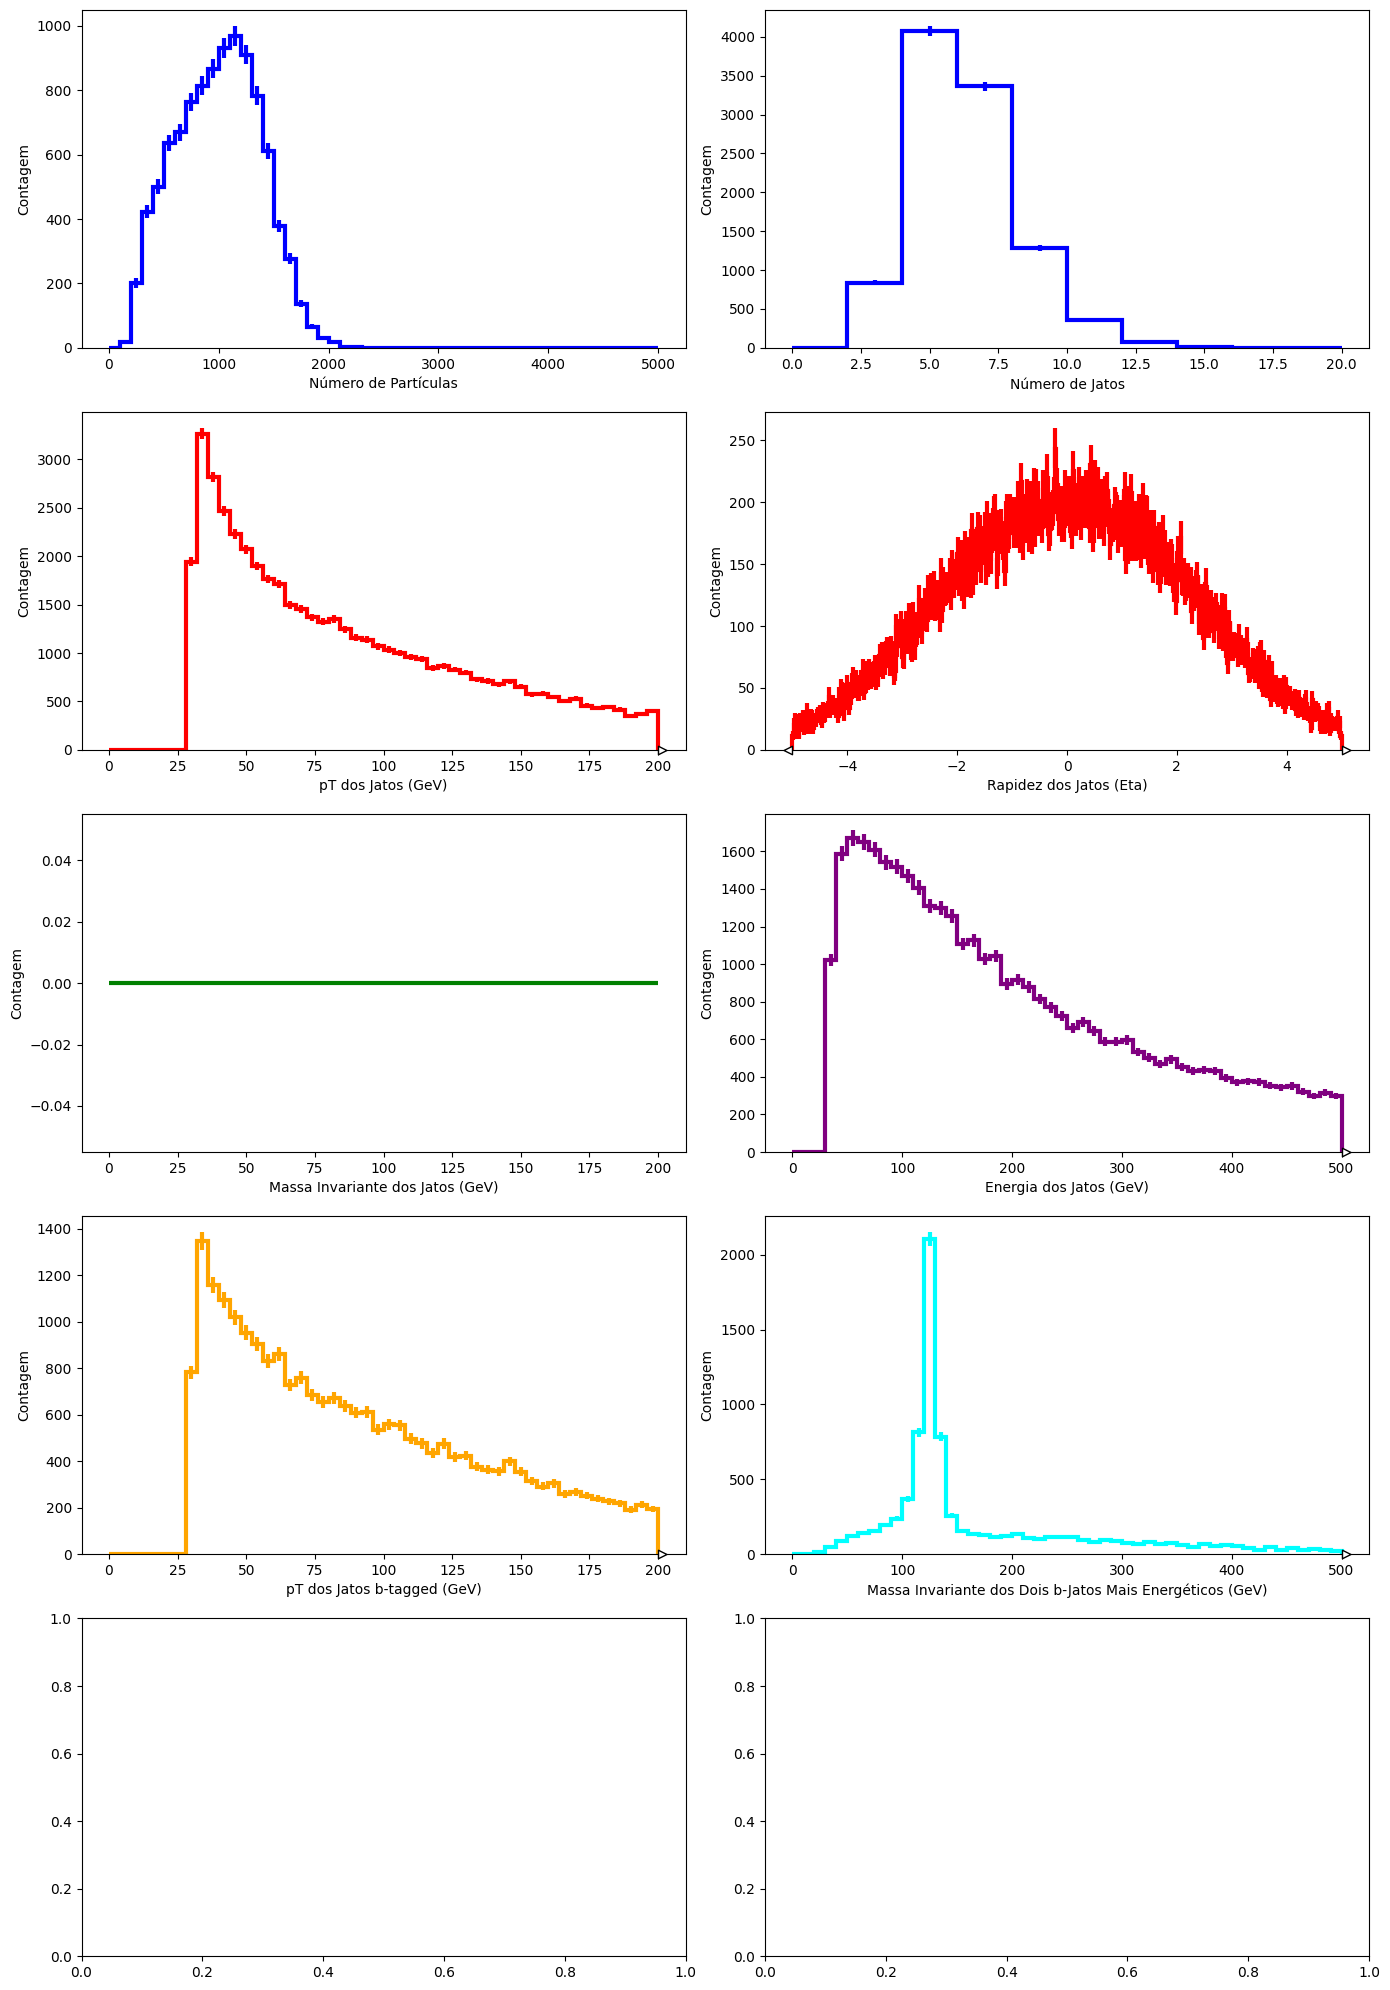

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  # Massa invariante dos jatos
histo_npart = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()  # Energia dos jatos
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  # Separação entre jatos (Rjj)
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos b-tagged
histo_bjets_mass = hist.Hist.new.Reg(50, 0., 500.).Double()  # Massa invariante dos dois b-jatos mais energéticos

# Função para ler o arquivo HEPMC e extrair os eventos
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)  # Adiciona o evento ao arquivo
    return events

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para identificar descendentes de quarks b ao longo da cadeia de decaimento
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  # IDs do PDG para quarks b (5) e b~ (-5)
            to_process = [particle]
            while to_process:
                current = to_process.pop()
                if current.end_vertex:
                    to_process.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants  # Fazer utilizando as particulas de estado final

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = jet.phi() - b['phi']
        # Ajustar delta_phi para estar no intervalo [-pi, pi]
        delta_phi = np.arctan2(np.sin(delta_phi), np.cos(delta_phi))
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    # Filtrar partículas com status 1 (partículas finais)
    particles = [p for p in event.particles if p.status == 1]
    
    # Converter partículas para objetos PseudoJet do FastJet
    fj_particles = [
        fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e)
        for p in particles
    ]

    # Escolher o algoritmo de clustering (anti-kT, por exemplo)
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)  # Radius de 0.4
    
    # Clustering dos jatos
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(30.0)  # Jatos com pT > 30 GeV

    # Preencher histogramas gerais de jatos
    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())
        histo_jets_eta.fill(jet.eta())
        histo_jets_energy.fill(jet.e())

    # Identificar descendentes de quarks b
    b_descendants = get_b_descendants(event)

    # Identificar jatos b-tagged
    b_jets = []
    for jet in jets:
        if is_b_tagged(jet, b_descendants):
            histo_bjets_pt.fill(jet.pt())
            b_jets.append(jet)

    # Preencher histograma de massa invariante para os dois b-jatos mais energéticos
    if len(b_jets) >= 2:
        b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
        histo_bjets_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

    # Preencher histograma de número de partículas
    histo_npart.fill(len(particles))

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(5, 2, figsize=(14, 20))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Contagem')

    histo_bjets_pt.plot(ax=ax[3, 0], ls="-", color="orange", lw=3)
    ax[3, 0].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem')

    histo_bjets_mass.plot(ax=ax[3, 1], ls="-", color="cyan", lw=3)
    ax[3, 1].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem')

    plt.tight_layout()
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {len(events)}...")
    analyze_event(event)

# Plotar os histogramas
plot_histograms()


Processando evento 0 de 10000...
Processando evento 1000 de 10000...
Processando evento 2000 de 10000...
Processando evento 3000 de 10000...
Processando evento 4000 de 10000...
Processando evento 5000 de 10000...
Processando evento 6000 de 10000...
Processando evento 7000 de 10000...
Processando evento 8000 de 10000...
Processando evento 9000 de 10000...


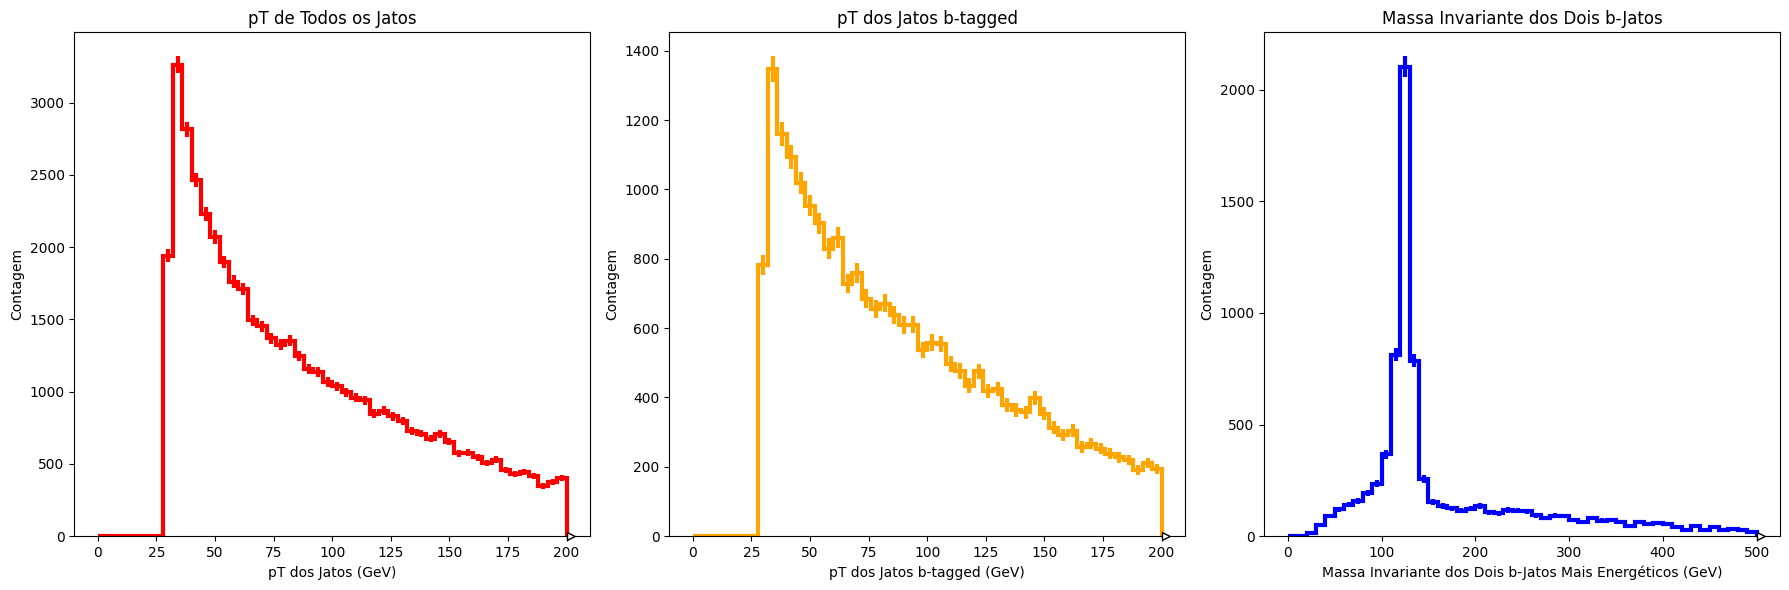

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  # Massa invariante dos jatos
histo_npart = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()  # Energia dos jatos
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  # Separação entre jatos (Rjj)
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos b-tagged
histo_bjets_invariant_mass = hist.Hist.new.Reg(50, 0., 500.).Double()  # Massa invariante dos dois b-jatos mais energéticos

# Função para ler o arquivo HEPMC e extrair os eventos
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)  # Adiciona o evento ao arquivo
    return events

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para identificar descendentes de quarks b ao longo da cadeia de decaimento
def get_b_descendants(event):
    b_descendants = []
    for particle in event.particles:
        if abs(particle.pid) == 5:  # IDs do PDG para quarks b (5) e b~ (-5)
            to_process = [particle]
            while to_process:
                current = to_process.pop()
                if current.end_vertex:
                    to_process.extend(current.end_vertex.particles_out)
                b_descendants.append({
                    'eta': get_eta(current),
                    'phi': np.arctan2(current.momentum.y, current.momentum.x)
                })
    return b_descendants  # Fazer utilizando as particulas de estado final

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, b_descendants, cone_radius=0.4):
    for b in b_descendants:
        delta_eta = jet.eta() - b['eta']
        delta_phi = jet.phi() - b['phi']
        if delta_phi > np.pi:
            delta_phi -= 2 * np.pi
        elif delta_phi < -np.pi:
            delta_phi += 2 * np.pi
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            return True
    return False

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    # Filtrar partículas com status 1 (partículas finais)
    particles = [p for p in event.particles if p.status == 1]

    # Converter partículas para objetos PseudoJet do FastJet
    fj_particles = [
        fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e)
        for p in particles
    ]

    # Escolher o algoritmo de clustering (anti-kT, por exemplo)
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)  # Radius de 0.4

    # Clustering dos jatos
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(30.0)  # Jatos com pT > 30 GeV

    # Preencher histogramas gerais de jatos
    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())
        histo_jets_eta.fill(jet.eta())
        histo_jets_energy.fill(jet.e())

    # Identificar descendentes de quarks b
    b_descendants = get_b_descendants(event)

    # Selecionar os b-jatos e preencher histograma de pT e massa invariante
    b_jets = []
    for jet in jets:
        if is_b_tagged(jet, b_descendants):
            histo_bjets_pt.fill(jet.pt())
            b_jets.append(jet)

    # Preencher histograma de massa invariante dos dois b-jatos mais energéticos
    if len(b_jets) >= 2:
        b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
        histo_bjets_invariant_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    histo_jets_pt.plot(ax=ax[0], ls="-", color="red", lw=3)
    ax[0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem', title='pT de Todos os Jatos')

    histo_bjets_pt.plot(ax=ax[1], ls="-", color="orange", lw=3)
    ax[1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem', title='pT dos Jatos b-tagged')

    histo_bjets_invariant_mass.plot(ax=ax[2], ls="-", color="blue", lw=3)
    ax[2].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos')

    plt.tight_layout()
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {len(events)}...")
    analyze_event(event)

# Plotar os histogramas
plot_histograms()


Processando evento 0 de 10000...
Processando evento 1000 de 10000...
Processando evento 2000 de 10000...
Processando evento 3000 de 10000...
Processando evento 4000 de 10000...
Processando evento 5000 de 10000...
Processando evento 6000 de 10000...
Processando evento 7000 de 10000...
Processando evento 8000 de 10000...
Processando evento 9000 de 10000...


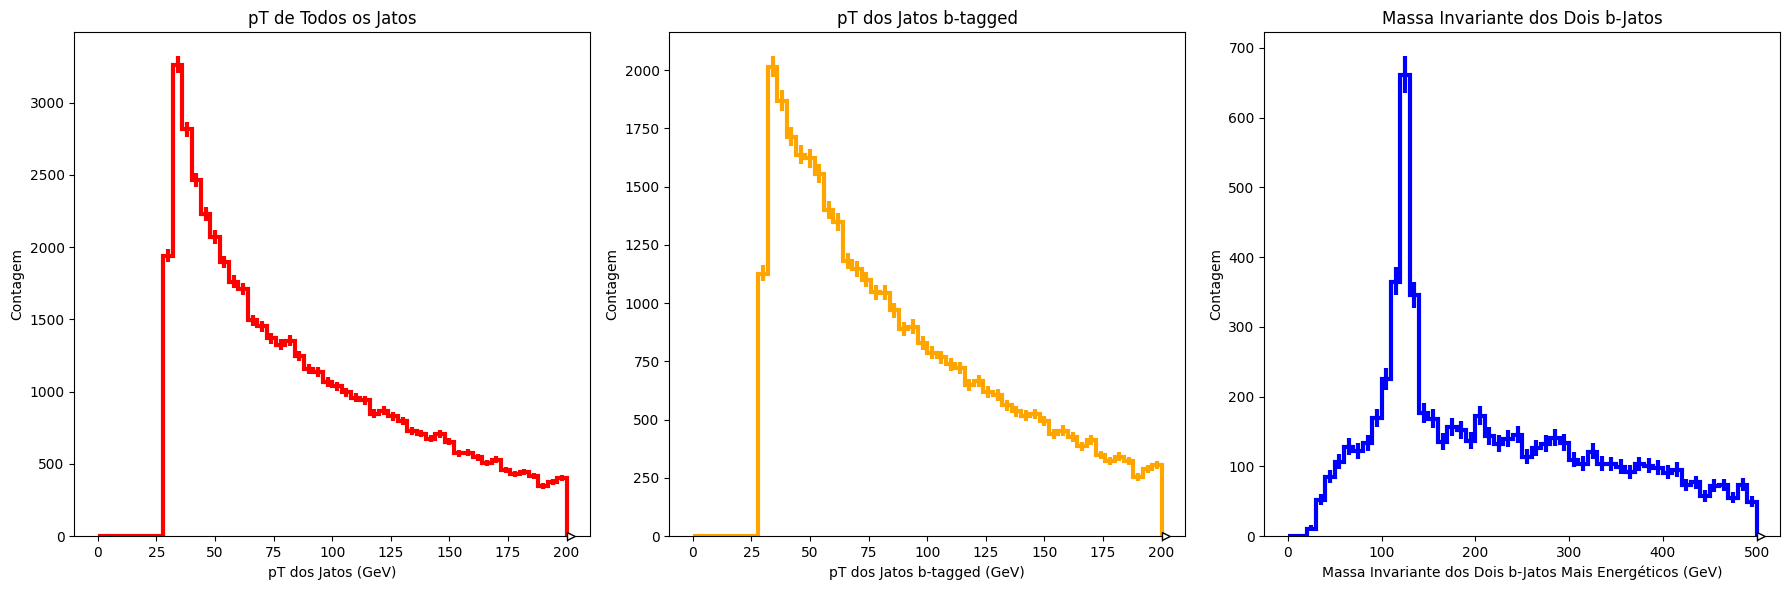

In [4]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt = hist.Hist.new.Reg(50, 0., 200.).Double()  # pT dos jatos identificados como b-tagged
histo_bjets_invariant_mass = hist.Hist.new.Reg(50, 0., 500.).Double()  # Massa invariante dos dois b-jatos mais energéticos

# Função para ler o arquivo HEPMC e extrair os eventos
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)  # Adiciona o evento ao arquivo
    return events

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para identificar partículas finais dentro de um cone ao redor de um jato
def particles_in_jet(jet, particles, cone_radius=0.4):
    jet_eta = jet.eta()
    jet_phi = jet.phi()
    constituents = []

    for p in particles:
        eta = get_eta(p)
        phi = np.arctan2(p.momentum.y, p.momentum.x)

        delta_eta = jet_eta - eta
        delta_phi = jet_phi - phi
        if delta_phi > np.pi:
            delta_phi -= 2 * np.pi
        elif delta_phi < -np.pi:
            delta_phi += 2 * np.pi

        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        if delta_r < cone_radius:
            constituents.append(p)

    return constituents

# Função para determinar se um jato é identificado como b-tagged com base em propriedades observáveis
def is_b_tagged_from_finals(jet, particles, cone_radius=0.4):
    constituents = particles_in_jet(jet, particles, cone_radius)
    
    # Critérios experimentais simulados
    def get_charge(pid):
        # Simplificação para deduzir a carga com base no código PDG
        if abs(pid) in [11, 13, 211]:
            return -1 if pid > 0 else 1
        elif abs(pid) in [2212]:
            return 1 if pid > 0 else -1
        return 0

    n_charged = sum(1 for p in constituents if get_charge(p.pid) != 0)
    total_energy = sum(p.momentum.e for p in constituents)
    jet_mass = np.sqrt(max(0, total_energy**2 - sum(
        (p.momentum.x for p in constituents))**2 - sum(
        (p.momentum.y for p in constituents))**2 - sum(
        (p.momentum.z for p in constituents))**2))

    # Condições baseadas em propriedades de jatos b reais
    if n_charged > 3 and total_energy > 50 and 5 < jet_mass < 50:
        return True
    return False

# Função para analisar o evento e preencher os histogramas
def analyze_event(event):
    # Filtrar partículas com status 1 (partículas finais)
    particles = [p for p in event.particles if p.status == 1]

    # Converter partículas para objetos PseudoJet do FastJet
    fj_particles = [
        fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e)
        for p in particles
    ]

    # Escolher o algoritmo de clustering (anti-kT, por exemplo)
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)  # Radius de 0.4

    # Clustering dos jatos
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(30.0)  # Jatos com pT > 30 GeV

    # Preencher histograma geral de jatos
    histo_njets.fill(len(jets))
    for jet in jets:
        histo_jets_pt.fill(jet.pt())

    # Selecionar os b-jatos com base nas partículas finais
    b_jets = []
    for jet in jets:
        if is_b_tagged_from_finals(jet, particles):
            histo_bjets_pt.fill(jet.pt())
            b_jets.append(jet)

    # Preencher histograma de massa invariante dos dois b-jatos mais energéticos
    if len(b_jets) >= 2:
        b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
        histo_bjets_invariant_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    histo_jets_pt.plot(ax=ax[0], ls="-", color="red", lw=3)
    ax[0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem', title='pT de Todos os Jatos')

    histo_bjets_pt.plot(ax=ax[1], ls="-", color="orange", lw=3)
    ax[1].set(xlabel='pT dos Jatos b-tagged (GeV)', ylabel='Contagem', title='pT dos Jatos b-tagged')

    histo_bjets_invariant_mass.plot(ax=ax[2], ls="-", color="blue", lw=3)
    ax[2].set(xlabel='Massa Invariante dos Dois b-Jatos Mais Energéticos (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos')

    plt.tight_layout()
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
for ievt, event in enumerate(events):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {len(events)}...")
    analyze_event(event)

# Plotar os histogramas
plot_histograms()
